### Get source parameters

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal
import scipy.stats

We provide 3 data sets in the `Spritz` release: 

- `mbhb1-training.h5`:  MBHB dataset 1 is MBHB#4 from sangria data (a loud event), with 3 short glitches on top of it
- `mbhb2-training.h5`: MBHB dataset 2 is MBHB#1 from sangria data, with a ~5h glitch on top of it
- `vgb-training.h5`: VGB dataset is the 36 verification binaries of sangria data, with an LPF like distribution of glitches on top of them 

We also distribute the `orbits.h5` file which have been used in the simulation. 

## Loading the first MBHB training dataset (66Mb)

In [2]:
#!wget https://lisa-ldc.lal.in2p3.fr/media/uploads/LDC2_spritz_mbhb1_training_v1.h5

Training file contains the following dataset:
- `sky/cat` with source parameters
- `sky/tdi` with noise free and artifact free TDI (t, X, Y, Z) 4D array
- `obs/tdi` with noise and artifacts
- `noisefree/tdi` with artifacts but noise free TDI
- `clean/tdi` with noise but artifacts free TDI

Additional parameter of the simulation can be found in `instru/config` and `obs/config` and `sky/config`. 

### Parse hdf5 file

In [3]:
training_file = 'LDC2_spritz_mbhb1_training_v1.h5'
def print_attrs(name, obj):
    shift = name.count('/') * '    '
    print(shift + name)
    for key, val in obj.attrs.items():
        print(shift + '    ' + f"{key}: {val}")

fid = h5py.File(training_file)
fid.visititems(print_attrs)

clean
    clean/tdi
        coord: t
        dt: 5.0
        t0: 8899200.0
        units: dimensionless
header
    header/date
instru
    instru/config
        instru/config/LISA_AAFILTER_ATTENUATION
        instru/config/LISA_AAFILTER_TRANSITION_BAND_0
        instru/config/LISA_AAFILTER_TRANSITION_BAND_1
        instru/config/LISA_ACC_NOISE_A_LEVEL
        instru/config/LISA_ACC_NOISE_F_KNEE
        instru/config/LISA_ACC_NOISE_USE_PZM
        instru/config/LISA_ADC_RECURSION_ORDER
        instru/config/LISA_BACKLINK_NOISE_A_LEVEL
        instru/config/LISA_BACKLINK_NOISE_F_KNEE
        instru/config/LISA_DEBUG_CLOCK_OFFSETS
        instru/config/LISA_FREQUENCY_OFFSETS_12
        instru/config/LISA_FREQUENCY_OFFSETS_13
        instru/config/LISA_FREQUENCY_OFFSETS_21
        instru/config/LISA_FREQUENCY_OFFSETS_23
        instru/config/LISA_FREQUENCY_OFFSETS_31
        instru/config/LISA_FREQUENCY_OFFSETS_32
        instru/config/LISA_GLITCH_FILE
        instru/config/LISA_GW_FILE_FS


### Generate a new file with gaps indices in configuration

In [4]:
tdi = fid["obs/tdi"][()].squeeze()
dt = tdi["t"][1]-tdi["t"][0]

In [5]:
gaps = tdi["t"][np.isnan(tdi["X"])]
start = np.hstack([np.array([gaps[0]]), (gaps[1:])[gaps[1:]-gaps[:-1]>dt]])
end = np.hstack([(gaps[:-1])[gaps[1:]-gaps[:-1]>dt], np.array([gaps[-1]])])
gaps_indices = np.vstack([start, end])

In [6]:
fid.close() # close read-only mode
with h5py.File(training_file, 'a') as fid:
    fid.create_dataset('obs/config/gaps', data=gaps_indices)

Let's continue the tutorial with the modified file. 

In [8]:
fid = h5py.File(training_file)
fid.visititems(print_attrs)

clean
    clean/tdi
        coord: t
        dt: 5.0
        t0: 8899200.0
        units: dimensionless
header
    header/date
instru
    instru/config
        instru/config/LISA_AAFILTER_ATTENUATION
        instru/config/LISA_AAFILTER_TRANSITION_BAND_0
        instru/config/LISA_AAFILTER_TRANSITION_BAND_1
        instru/config/LISA_ACC_NOISE_A_LEVEL
        instru/config/LISA_ACC_NOISE_F_KNEE
        instru/config/LISA_ACC_NOISE_USE_PZM
        instru/config/LISA_ADC_RECURSION_ORDER
        instru/config/LISA_BACKLINK_NOISE_A_LEVEL
        instru/config/LISA_BACKLINK_NOISE_F_KNEE
        instru/config/LISA_DEBUG_CLOCK_OFFSETS
        instru/config/LISA_FREQUENCY_OFFSETS_12
        instru/config/LISA_FREQUENCY_OFFSETS_13
        instru/config/LISA_FREQUENCY_OFFSETS_21
        instru/config/LISA_FREQUENCY_OFFSETS_23
        instru/config/LISA_FREQUENCY_OFFSETS_31
        instru/config/LISA_FREQUENCY_OFFSETS_32
        instru/config/LISA_GLITCH_FILE
        instru/config/LISA_GW_FILE_FS


### Get source parameters

In [9]:
fid = h5py.File(training_file)
names = fid["sky/cat"].dtype.names
cat_mbhb = dict(zip(names, [fid["sky/cat"][name] for name in names]))
print(cat_mbhb)

{'EclipticLatitude': -0.30300442294174235, 'EclipticLongitude': 1.2925183861048521, 'PolarAngleOfSpin1': 1.2031361791056812, 'PolarAngleOfSpin2': 2.097303543065685, 'Spin1': 0.747377, 'Spin2': 0.8388, 'Mass1': 1323277.47932, 'Mass2': 612485.5060299999, 'CoalescenceTime': 11526944.921879262, 'PhaseAtCoalescence': 1.2201968860015653, 'InitialPolarAngleL': 2.6919824500032945, 'InitialAzimuthalAngleL': 1.808398497592109, 'Redshift': 1.73941, 'Distance': 13470.983558972537, 'ObservationDuration': 31558149.763545603, 'Cadence': 3.0}


In [10]:
# get units
units = [(k, fid['sky/cat'].attrs.get(k)) for k in names]
units = dict(units)
units

{'EclipticLatitude': 'rad',
 'EclipticLongitude': 'rad',
 'PolarAngleOfSpin1': 'rad',
 'PolarAngleOfSpin2': 'rad',
 'Spin1': '1',
 'Spin2': '1',
 'Mass1': 'Msun',
 'Mass2': 'Msun',
 'CoalescenceTime': 's',
 'PhaseAtCoalescence': 'rad',
 'InitialPolarAngleL': 'rad',
 'InitialAzimuthalAngleL': 'rad',
 'Redshift': '1',
 'Distance': 'Mpc',
 'ObservationDuration': None,
 'Cadence': None}

### Get TDI with noise and artifacts

Gaps correspond to np.nan values. 

Text(0.5, 0, 'Freq [Hz]')

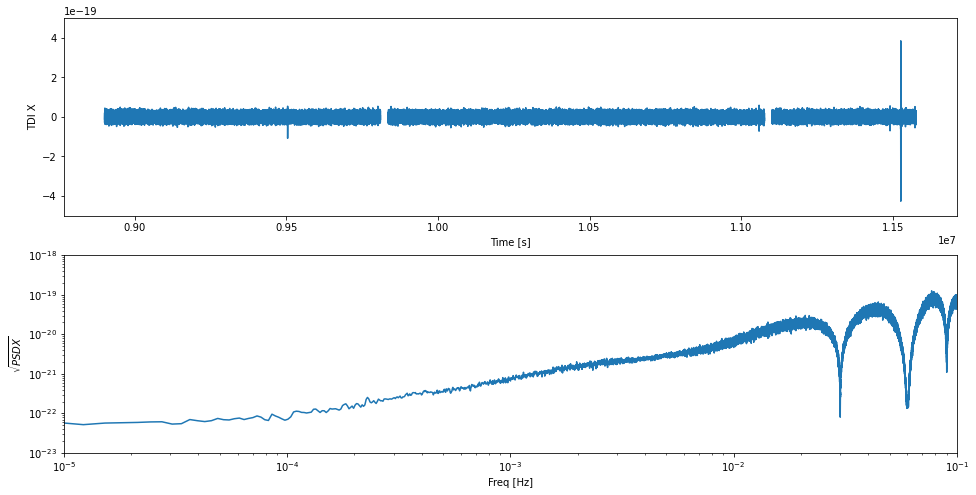

In [11]:
tdi = fid["obs/tdi"][()].squeeze()
dt = tdi['t'][1]-tdi['t'][0]

start = 200
tdix_wo_nan = tdi["X"].copy()[start:]
gaps = np.isnan(tdi['X'])[start:]
tdix_wo_nan[gaps] = 0 # set to 0 to compute PSD



plt.figure(figsize=(16,8))
plt.subplot(211)
plt.plot(tdi['t'][start:], tdi["X"][start:])
plt.axis([None, None, -0.5e-18, 0.5e-18])
plt.ylabel("TDI X")
plt.xlabel("Time [s]")

plt.subplot(212)
f, psdX =  scipy.signal.welch(tdix_wo_nan, fs=1.0/dt, window='hanning', nperseg=256*256)
plt.loglog(f, np.sqrt(psdX))
plt.axis([1e-5, 1e-1, 1e-23, 1e-18])
plt.ylabel("$\sqrt{PSD X}$")
plt.xlabel("Freq [Hz]")

### Visualization of the data artifacts with spectrogram

#### Unormalized spectrogram

In [12]:
# Choose the length of averaging segments
nperseg = int(1e4 / dt)
# Compute spectrogram
fxx, txx, Sxx = scipy.signal.spectrogram(tdix_wo_nan, 
                                         fs=1.0/dt, 
                                         nperseg=nperseg,
                                         scaling='density',
                                         return_onesided=True)
# Find values where it is zero
ixx = np.where(Sxx==0)
Sxx[ixx] = np.min(Sxx[Sxx!=0])/10

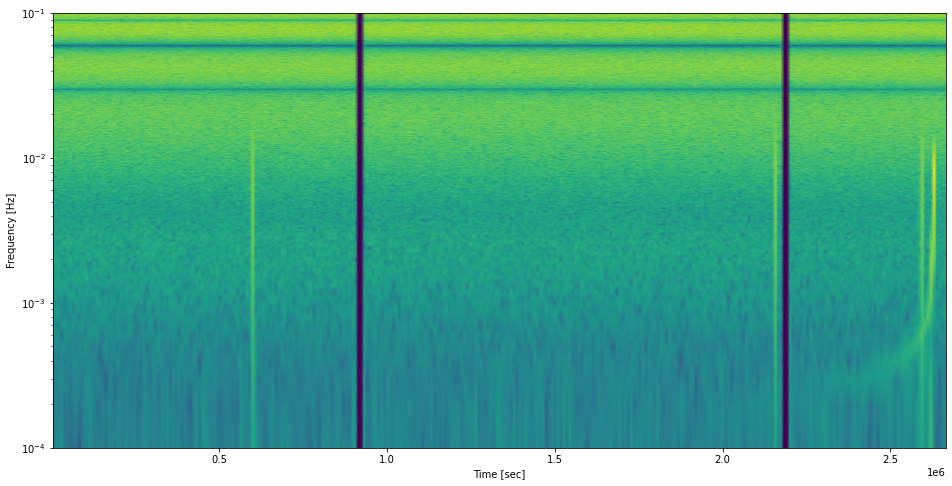

In [13]:
plt.figure(figsize=(16,8))
plt.pcolormesh(txx, fxx[fxx>0], np.log10(Sxx[fxx>0]), 
               shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
# plt.ylim([np.min(fxx), np.max(fxx)])
plt.show()

#### Normalize the spectrogram with the noise PSD

We provide a list of predefined noise model like "Proposal", "SciRDv1", "MRDv1", with analytic formula based on a given acceleration (low freq) and OMS (high freq) noise levels. 

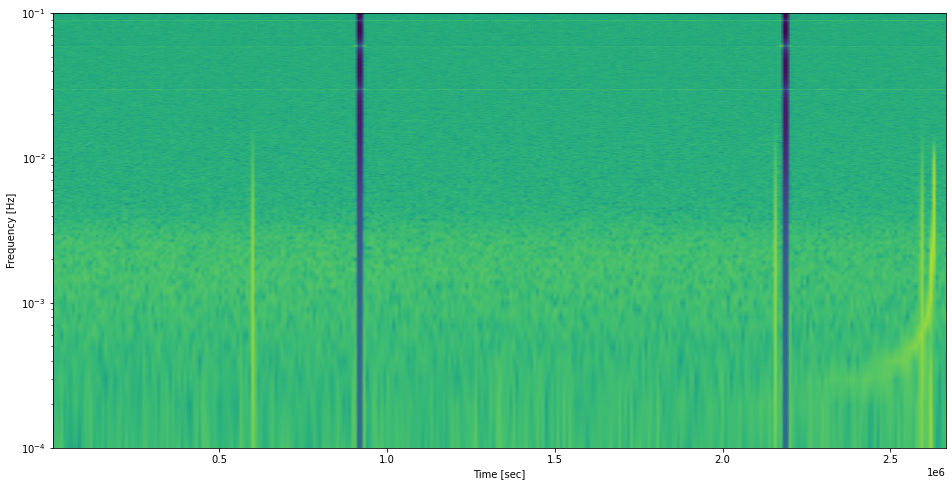

In [14]:
from ldc.lisa.noise import get_noise_model

noise_model = "MRDv1" 
nmodel = get_noise_model(noise_model, fxx[fxx>0])
npsd = nmodel.psd(option='X', tdi2=True) # could be A, E, XY

plt.figure(figsize=(16,8))
plt.pcolormesh(txx, fxx[fxx>0], 
               np.log10(Sxx[fxx>0]/npsd[:, np.newaxis]), 
               shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
# plt.ylim([np.min(fxx), np.max(fxx)])
plt.show()

### Get pipeline configuration

In [15]:
cfg = dict(zip(fid["obs/config"].keys(), [v[()] for v in fid["obs/config"].values()]))
cfg

{'accnoise': 2.4e-15,
 'accnoise_seed_1_over_f2_12': 71,
 'accnoise_seed_1_over_f2_13': 72,
 'accnoise_seed_1_over_f2_21': 73,
 'accnoise_seed_1_over_f2_23': 74,
 'accnoise_seed_1_over_f2_31': 76,
 'accnoise_seed_1_over_f2_32': 75,
 'accnoise_seed_1_over_f_12': 61,
 'accnoise_seed_1_over_f_13': 62,
 'accnoise_seed_1_over_f_21': 63,
 'accnoise_seed_1_over_f_23': 64,
 'accnoise_seed_1_over_f_31': 66,
 'accnoise_seed_1_over_f_32': 65,
 'backlink_ref_seed1_over_f_12': 41,
 'backlink_ref_seed1_over_f_13': 42,
 'backlink_ref_seed1_over_f_21': 43,
 'backlink_ref_seed1_over_f_23': 44,
 'backlink_ref_seed1_over_f_31': 45,
 'backlink_ref_seed1_over_f_32': 46,
 'backlink_ref_seed_f_12': 21,
 'backlink_ref_seed_f_13': 22,
 'backlink_ref_seed_f_21': 23,
 'backlink_ref_seed_f_23': 24,
 'backlink_ref_seed_f_31': 25,
 'backlink_ref_seed_f_32': 26,
 'backlink_tm_seed1_over_f_12': 31,
 'backlink_tm_seed1_over_f_13': 32,
 'backlink_tm_seed1_over_f_21': 33,
 'backlink_tm_seed1_over_f_23': 34,
 'backlink_t

In [16]:
cfg = dict(zip(fid["instru/config"].keys(), [v[()] for v in fid["instru/config"].values()]))
cfg

{'LISA_AAFILTER_ATTENUATION': 240,
 'LISA_AAFILTER_TRANSITION_BAND_0': 1.1,
 'LISA_AAFILTER_TRANSITION_BAND_1': 2.9,
 'LISA_ACC_NOISE_A_LEVEL': 2.4e-15,
 'LISA_ACC_NOISE_F_KNEE': 0.0004,
 'LISA_ACC_NOISE_USE_PZM': False,
 'LISA_ADC_RECURSION_ORDER': 1,
 'LISA_BACKLINK_NOISE_A_LEVEL': 3e-12,
 'LISA_BACKLINK_NOISE_F_KNEE': 0.002,
 'LISA_DEBUG_CLOCK_OFFSETS': False,
 'LISA_FREQUENCY_OFFSETS_12': 8.1,
 'LISA_FREQUENCY_OFFSETS_13': 1.4,
 'LISA_FREQUENCY_OFFSETS_21': -9.5,
 'LISA_FREQUENCY_OFFSETS_23': 9.2,
 'LISA_FREQUENCY_OFFSETS_31': 10.3,
 'LISA_FREQUENCY_OFFSETS_32': -11.6,
 'LISA_GLITCH_FILE': b'None',
 'LISA_GW_FILE_FS': 4.0,
 'LISA_GW_FILE_UPSAMPLING': 1.0,
 'LISA_GW_TYPE': b'file',
 'LISA_LASER_CENTRAL_FREQUENCY': 281600000.0,
 'LISA_LOCKING_SCHEME': b'N1c',
 'LISA_MEASUREMENT_DOWNSAMPLING': 1,
 'LISA_MEASUREMENT_FS': 4.0,
 'LISA_ORBIT_TYPE_0': b'file',
 'LISA_ORBIT_TYPE_1': b'ppr',
 'LISA_PHYSICS_FS': 4.0,
 'LISA_PRIMARY_LASER': b'12',
 'LISA_PUBLISH_BEATNOTE_COMPONENTS': True,
 'L

### Get noiseless and artifact free TDI data


In [17]:
tdi_gw = fid["sky/tdi"][()]
cfg_src = dict(zip(fid["sky/config"].keys(), [v[()] for v in fid["sky/config"].values()]))

In [18]:
cfg_src

{'approximant': b'IMRPhenomD',
 'catalogs': b'/data/Q3d_complete',
 'dt': 2.5,
 'gaps_seed': 1245,
 'glitch_deltat_0': 10,
 'glitch_deltat_1': 11,
 'glitch_inj_point_0': b'tm_12',
 'glitch_inj_point_1': b'tm_12',
 'glitch_inj_point_2': b'tm_12',
 'glitch_level_0': 2.202238810758277e-11,
 'glitch_level_1': 2.202238810758277e-11,
 'glitch_level_2': 2.202238810758277e-11,
 'glitch_t_inj_0': 110.0,
 'glitch_t_inj_1': 128.0,
 'glitch_t_inj_2': 133.0,
 'glitch_type': b'short',
 'indices_0': 185,
 'nsource': 1,
 'source_type': b'MBHB',
 't_max': 134.0,
 't_min': 103.0}

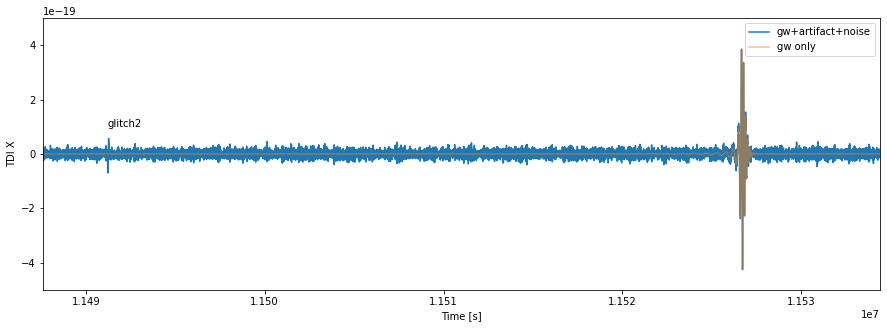

In [19]:
plt.figure(figsize=(15,5))
plt.plot(tdi['t'], tdi["X"], label="gw+artifact+noise")
plt.plot(tdi_gw['t'], tdi_gw["X"], label="gw only", alpha=0.5)
plt.annotate('glitch2', (cfg_src["glitch_t_inj_2"]*24*60*60, 1e-19))
plt.axis([cfg_src["glitch_t_inj_2"]*24*60*60 -60*60, cfg_src["t_max"]*24*60*60-60*60*12, -0.5e-18, 0.5e-18])
plt.ylabel("TDI X")
plt.xlabel("Time [s]")
plt.legend()

## Loading the VGB training dataset (770.6 MB)

### Get source parameters

In [22]:
training_file = 'LDC2_spritz_vgb_training_v1_uViCysf.h5'

fid = h5py.File(training_file)
names = fid["sky/cat"].dtype.names
cat_vgb = dict(zip(names, [fid["sky/cat"][name] for name in names]))
# print(cat_vgb)

# get units
units = [(k, fid['sky/cat'].attrs.get(k)) for k in names]
units = dict(units)
units

{'Name': None,
 'Amplitude': '1',
 'Distance': None,
 'Drift': None,
 'EclipticLatitude': 'rad',
 'EclipticLongitude': 'rad',
 'ErrorDistance': None,
 'ErrorMass1': None,
 'ErrorMass2': None,
 'Frequency': 'Hz',
 'FrequencyDerivative': 'Hz^2',
 'GalacticLatitude': None,
 'GalacticLongitude': None,
 'Inclination': 'rad',
 'InitialPhase': 'rad',
 'Mass1': None,
 'Mass2': None,
 'Period': None,
 'Polarization': 'rad'}

### Get TDI with noise and artifacts

In [23]:
tdi = fid["obs/tdi"][()].squeeze()
dt = tdi['t'][1]-tdi['t'][0]

start = 200
tdix_wo_nan = tdi["X"].copy()[start:]
gaps = np.isnan(tdi['X'])[start:]
tdix_wo_nan[gaps] = 0 # set to 0 to compute PSD

Text(0.5, 0, 'Freq [Hz]')

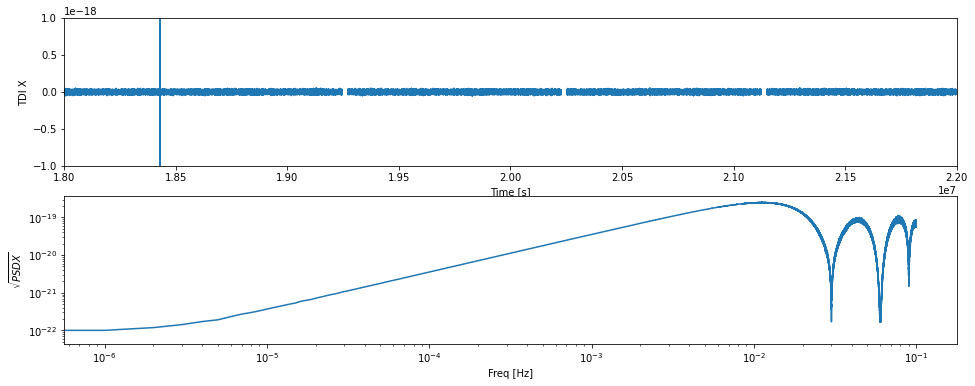

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(211)
plt.plot(tdi['t'][start:], tdi["X"][start:])
plt.ylabel("TDI X")
plt.xlabel("Time [s]")
plt.xlim([1.8e7, 2.2e7])
plt.ylim([-1e-18, 1e-18])

plt.subplot(212)
# plt.figure(figsize=(16, 6))
f, psdX =  scipy.signal.welch(tdix_wo_nan, fs=1.0/dt, window='hanning', nperseg=int(1e6 / dt))
plt.loglog(f, np.sqrt(psdX))
plt.ylabel("$\sqrt{PSD X}$")
plt.xlabel("Freq [Hz]")

### Visualization of the data artifacts with spectrogram

In [25]:
# Choose the length of averaging segments
nperseg = int(1e4 / dt)
# Compute spectrogram
fxx, txx, Sxx = scipy.signal.spectrogram(tdix_wo_nan, 
                                         fs=1.0/dt, 
                                         nperseg=nperseg,
                                         scaling='density',
                                         return_onesided=True)
# Find values where it is zero
ixx = np.where(Sxx==0)
Sxx[ixx] = np.min(Sxx[Sxx!=0])/10

In [26]:
# Re-weight by the noise PSD
nmodel = get_noise_model(noise_model, fxx[fxx>0])
npsd = nmodel.psd(option='X', tdi2=True)

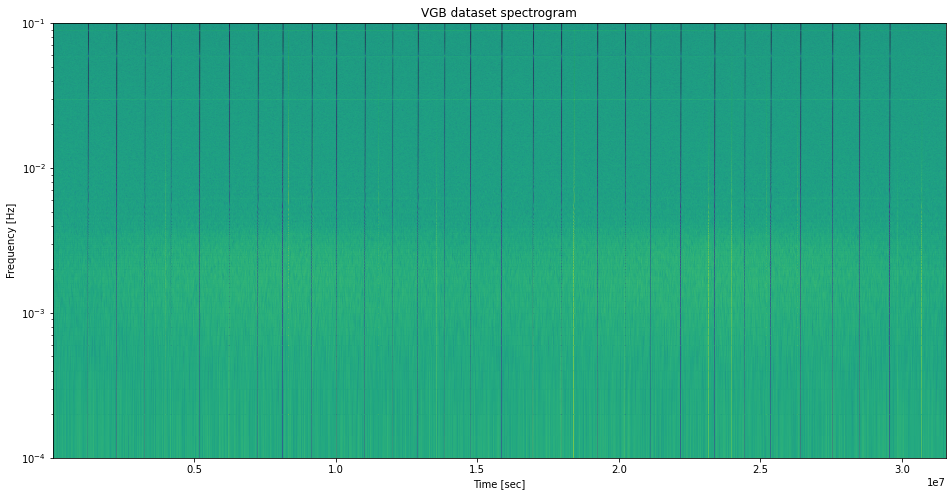

In [27]:
plt.figure(figsize=(16,8))
plt.pcolormesh(txx, fxx[fxx>0], np.log10(Sxx[fxx>0]/npsd[:, np.newaxis]), 
               shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("VGB dataset spectrogram")
plt.yscale('log')
# plt.ylim([np.min(fxx), np.max(fxx)])
plt.show()

### Get TDI without noise

In [28]:
tdi_noiseless = fid["sky/tdi"][()].squeeze()
tdi_x = tdi_noiseless["X"].copy()[start:]

Text(0.5, 0, 'Freq [Hz]')

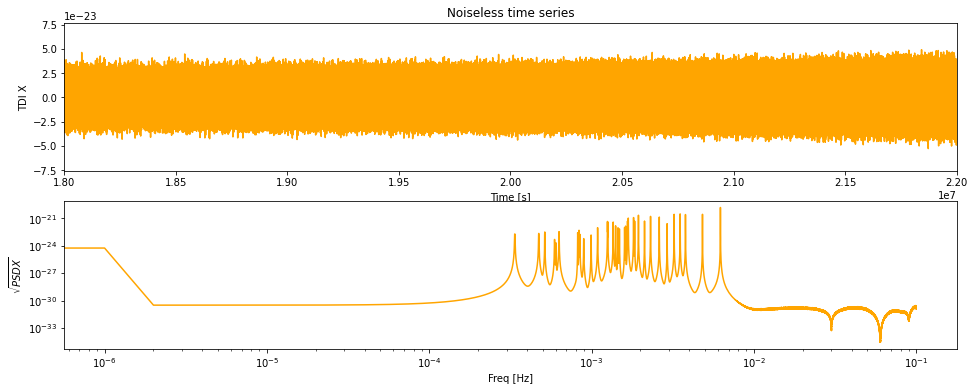

In [29]:
start = 200

plt.figure(figsize=(16, 6))
plt.subplot(211)
plt.plot(tdi_noiseless['t'][start:], tdi_x, color='orange')
plt.ylabel("TDI X")
plt.xlabel("Time [s]")
plt.xlim([1.8e7, 2.2e7])
# plt.ylim([-1e-18, 1e-18])
plt.title("Noiseless time series")

plt.subplot(212)
f, psdX_noiseless =  scipy.signal.welch(tdi_x, fs=1.0/dt, window='hanning', nperseg=int(1e6 / dt))
plt.loglog(f, np.sqrt(psdX_noiseless), color='orange')
plt.ylabel("$\sqrt{PSD X}$")
plt.xlabel("Freq [Hz]")

### Compare the noisy and noiseless data

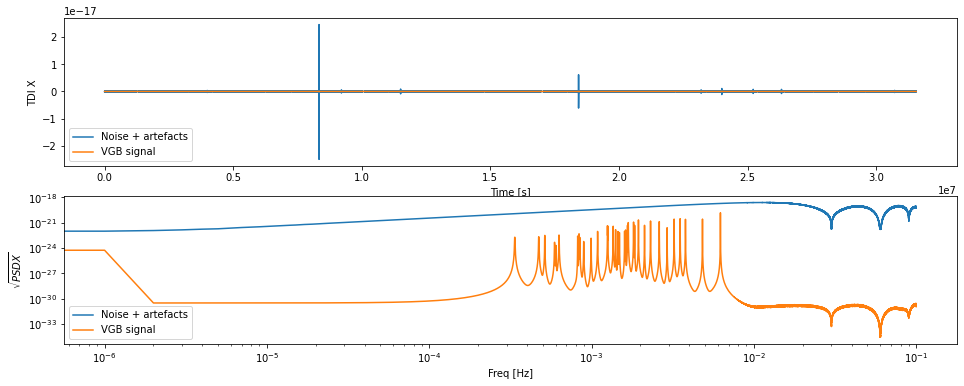

In [30]:
# Subtract signal from noise
tdi_noise = tdi['X'][start:] - tdi_x
tdi_noise[gaps] = 0.0

plt.figure(figsize=(16, 6))
plt.subplot(211)
plt.plot(tdi['t'][start:], tdi_noise, label='Noise + artefacts')
plt.plot(tdi['t'][start:], tdi_x, label='VGB signal')
plt.ylabel("TDI X")
plt.xlabel("Time [s]")
# plt.xlim([1.8e7, 2.2e7])
# plt.ylim([-1e-18, 1e-18])
plt.legend(loc='lower left')

plt.subplot(212)
f, psdX_noise =  scipy.signal.welch(tdi_noise, fs=1.0/dt, window='hanning', nperseg=int(1e6 / dt))
plt.loglog(f, np.sqrt(psdX_noise), label='Noise + artefacts')
plt.loglog(f, np.sqrt(psdX_noiseless), label='VGB signal')
plt.ylabel("$\sqrt{PSD X}$")
plt.xlabel("Freq [Hz]")
plt.legend(loc='lower left')

plt.show()

### Flagging the glitches

In [31]:
# Define a low-pass filter function
def low_pass_filter(y, n=5, fc=0.05, fs=10.0):

    b, a = scipy.signal.butter(n, fc, 'low', analog=False, fs=fs)
    y = scipy.signal.filtfilt(b, a, y)

    return y

In [32]:
# Low-pass filter the data to better see the glitches
tdi_x_filtered = low_pass_filter(tdix_wo_nan, n=5, fc=0.05, fs=1/dt)
# Re-add the gaps
tdi_x_filtered[gaps] = 0
tdi_t = tdi['t'][start:]

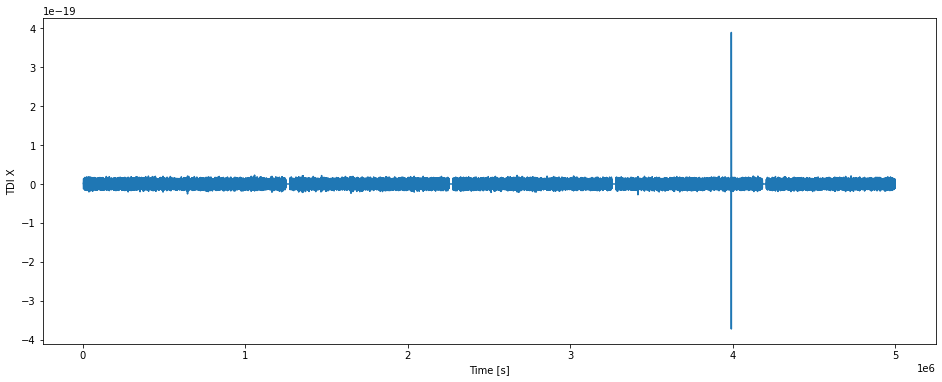

In [33]:
plt.figure(figsize=(16, 6))
i1 = 1000
i2 = 1000000
plt.plot(tdi_t[i1:i2], tdi_x_filtered[i1:i2], label='Filtered data')
plt.ylabel("TDI X")
plt.xlabel("Time [s]")
# plt.xlim([1.8e7, 2.2e7])
# plt.ylim([-1e-18, 1e-18])
# plt.legend()
plt.show()

In [34]:
# Detecting outliers by sigma-clipping
mad = scipy.stats.median_abs_deviation(tdi_x_filtered[i1:6000])
median = np.median(tdi_x_filtered[i1:6000])
maxval = np.max(np.abs(tdi_x_filtered[i1:i2]))
peaks, properties = scipy.signal.find_peaks(np.abs(tdi_x_filtered), height=7*mad, threshold=None, distance=1)

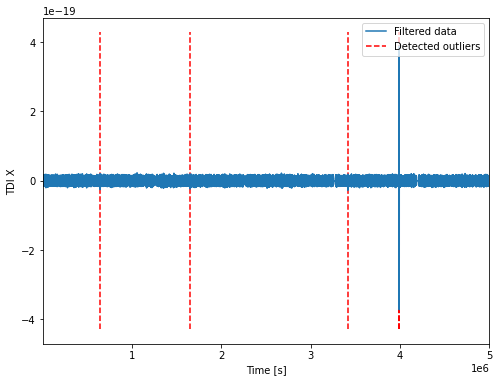

In [35]:

plt.figure(figsize=(8, 6))
plt.plot(tdi_t[i1:i2], tdi_x_filtered[i1:i2], label='Filtered data')
plt.vlines(tdi_t[peaks], ymin=-1.1*maxval, ymax=1.1*maxval, color='red', linestyle='dashed', label='Detected outliers')
plt.ylabel("TDI X")
plt.xlabel("Time [s]")
plt.xlim([tdi_t[i1], tdi_t[i2]])
# plt.ylim([-1e-18, 1e-18])
plt.legend(loc='upper right')
plt.show()

### Set glitched data to zero and re-compute the periodogram

In [36]:
# Turning glitches into gaps
tdix_wo_glitches = np.copy(tdix_wo_nan)
for pk in peaks:
    tdix_wo_glitches[pk-10:pk+10] = 0.0
f, psdX_wo_glitches =  scipy.signal.welch(tdix_wo_glitches, fs=1.0/dt, window='hanning', nperseg=int(1e6 / dt))

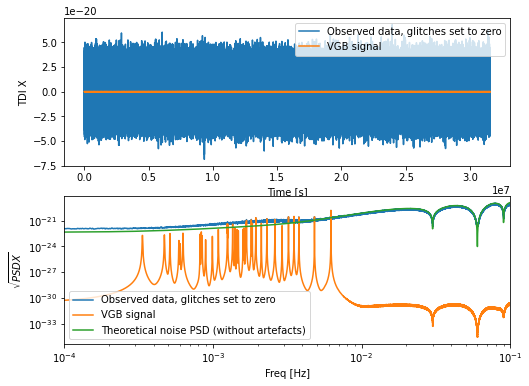

In [37]:
plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.plot(tdi['t'][start:], tdix_wo_glitches, label='Observed data, glitches set to zero', rasterized=True)
plt.plot(tdi['t'][start:], tdi_x, label='VGB signal', rasterized=True)
plt.ylabel("TDI X")
plt.xlabel("Time [s]")
# plt.xlim([1.8e7, 2.2e7])
# plt.ylim([-1e-18, 1e-18])
plt.legend(loc='upper right')

plt.subplot(212)
plt.loglog(f, np.sqrt(psdX_wo_glitches), label='Observed data, glitches set to zero', rasterized=True)
plt.loglog(f, np.sqrt(psdX_noiseless), label='VGB signal', rasterized=True)
plt.loglog(fxx[fxx>0], np.sqrt(npsd), label='Theoretical noise PSD (without artefacts)', rasterized=True)
plt.ylabel("$\sqrt{PSD X}$")
plt.xlabel("Freq [Hz]")
plt.xlim([1e-4, 1e-1])
plt.legend(loc='lower left')

plt.show()

# Some tips to deal with indexed data and frequency series

See `LDC2a-Sangria` notebook. 

## Galaxy free VGB data

In the following, we check that the VGB galaxy free data. 
The difference between the two data sets, with and without galaxy, gives a galaxy only series. 
We check that this galaxy series has it's expected amplitude and frequency shape, compared to instrumental noise. 

In [4]:
fid = h5py.File("LDC2_spritz_vgb_training_v1.h5")
tdi = fid["obs/tdi"][()].squeeze()
tdi_nf = fid["noisefree/tdi"][()].squeeze()
dt = tdi['t'][1]-tdi['t'][0]

tdi_gf = h5py.File("LDC2_spritz_vgb_training_galfree.h5")["obs/tdi"][()].squeeze()
tdi_gf_nf = h5py.File("LDC2_spritz_vgb_training_galfree.h5")["noisefree/tdi"][()].squeeze()
tdi_gf_sky = h5py.File("LDC2_spritz_vgb_training_galfree.h5")["sky/tdi"][()].squeeze()
tdi_X_diffg = tdi["X"]-tdi_gf["X"] # with - without galaxy -> galaxy only
tdi_X_diffn = tdi["X"]-tdi_nf["X"] # with - without noise -> noise only
tdi_X_g = tdi_gf_sky["X"]-tdi_gf_nf["X"] # sky - noisefree -> glitch only
start = 200

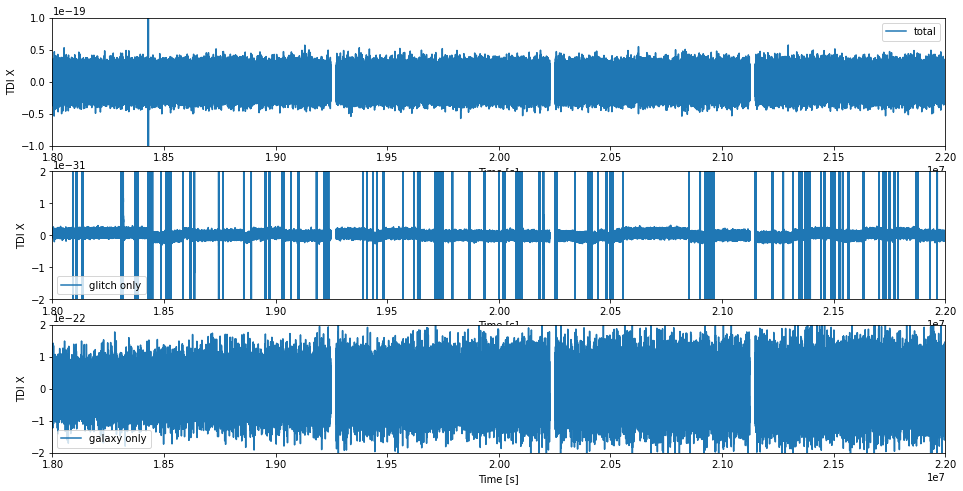

In [13]:
plt.figure(figsize=(16,8))
plt.subplot(311)
plt.plot(tdi['t'][start:], tdi["X"][start:], label='total')
plt.axis([None, None, -0.5e-18, 0.5e-18])
plt.ylabel("TDI X")
plt.xlabel("Time [s]")
plt.xlim([1.8e7, 2.2e7])
plt.ylim([-1e-19, 1e-19])
plt.legend()
plt.subplot(312)
plt.plot(tdi['t'][start:], tdi_X_g[start:], label='glitch only')
plt.axis([None, None, -0.5e-18, 0.5e-18])
plt.ylabel("TDI X")
plt.xlabel("Time [s]")
plt.xlim([1.8e7, 2.2e7])
plt.ylim([-2e-31, 2e-31])
plt.legend()
plt.subplot(313)
plt.plot(tdi['t'][start:], tdi_X_diffg[start:], label='galaxy only')
plt.axis([None, None, -0.5e-18, 0.5e-18])
plt.ylabel("TDI X")
plt.xlabel("Time [s]")
plt.xlim([1.8e7, 2.2e7])
plt.ylim([-2e-22, 2e-22])
plt.legend()


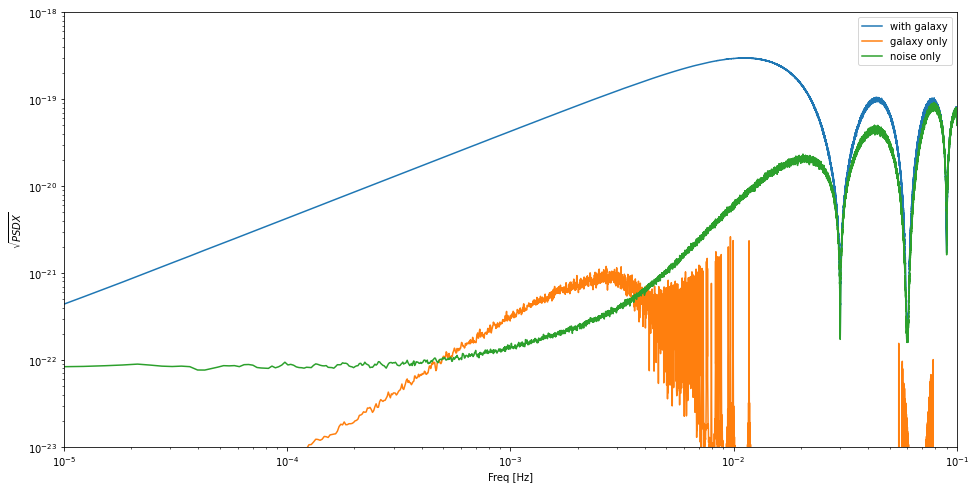

In [17]:
def get_psd(tdi):
    gaps = np.isnan(tdi)
    tdix_wo_nan = tdi.copy()
    tdix_wo_nan[gaps] = 0 # set to 0 to compute PSD
    f, psdX =  scipy.signal.welch(tdix_wo_nan, fs=1.0/dt, window='hanning', nperseg=256*256)
    return f, psdX

plt.figure(figsize=(16,8))
f, psdX = get_psd(tdi['X'][start:])
plt.loglog(f, np.sqrt(psdX), label='with galaxy')
f, psdX = get_psd(tdi_X_diffg.copy()[start:])
plt.loglog(f, np.sqrt(psdX), label='galaxy only')
f, psdX = get_psd(tdi_X_diffn.copy()[start:])
plt.loglog(f, np.sqrt(psdX), label='noise only')
plt.axis([1e-5, 1e-1, 1e-23, 1e-18])
plt.ylabel("$\sqrt{PSD X}$")
plt.xlabel("Freq [Hz]")
plt.legend()